# Differential Kinetics

One important concern is dealing with systems that represent multiple lineages and processes, where
genes are likely to show different kinetic regimes across subpopulations. Distinct cell states and
lineages are typically governed by different variations in the gene regulatory networks and may
hence exhibit different splicing kinetics. This gives rise to genes that display multiple trajectories
in phase space. 

To address this, the dynamical model can be used to perform a likelihood-ratio test for differential kinetics. This way, we can detect clusters that display kinetic behavior that cannot be well explained by a single model of the overall dynamics. Clustering cell types into their different kinetic regimes then allows fitting each regime separately.

For illustration, we apply differential kinetic analysis to [dentate gyrus neurogenesis](https://scvelo.readthedocs.io/scvelo.datasets.dentategyrus), which comprises multiple heterogeneous subpopulations.

In [1]:
# update to the latest version, if not done yet.
!pip install scvelo --upgrade --quiet

In [2]:
import scvelo as scv

In [3]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.settings.set_figure_params('scvelo')  # for beautified visualization


### Prepare the Data
Processing consists of gene selection, log-normalizing, and computing moments. See the previous tutorials for further explanation.

In [4]:
adata = scv.datasets.dentategyrus()

In [5]:
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)


Filtered out 11019 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


/mnt/d/scgeo/.venv/lib/python3.12/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)
/tmp/ipykernel_327811/3360365749.py:2: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
/mnt/d/scgeo/.venv/lib/python3.12/site-packages/scvelo/preprocessing/moments.py:71: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(
/mnt/d/scgeo/.venv/lib/python3.12/site-packages/scvelo/preprocessing/neighbors.py:233: DeprecationWarning: Automatic computation of PCA is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compu

computing neighbors
    finished (0:00:08) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


### Basic Velocity Estimation 

In [6]:
scv.tl.velocity(adata)
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/20 cores)
or disable the progress bar using `show_progress_bar=False`.


/mnt/d/scgeo/.venv/lib/python3.12/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=327811) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/mnt/d/scgeo/.venv/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/mnt/d/scgeo/.venv/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


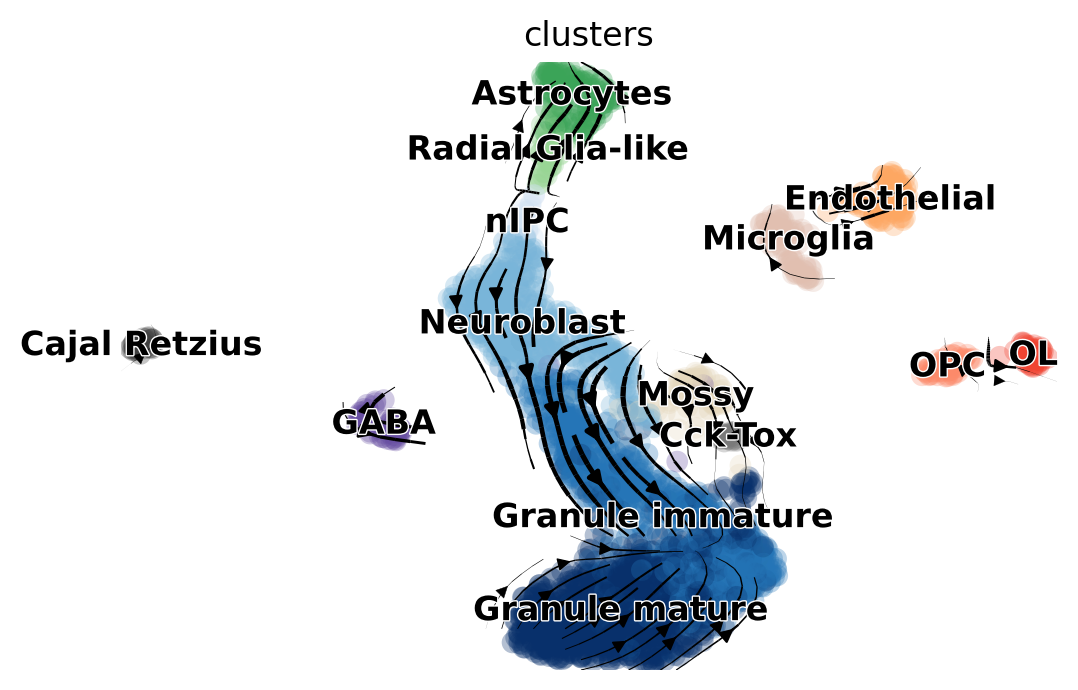

In [7]:
scv.pl.velocity_embedding_stream(adata, basis='umap')

### Differential Kinetic Test

Distinct cell types and lineages may exhibit different kinetics regimes as these can be governed by
a different network structure. Even if cell types or lineages are related, kinetics can be differential
due to alternative splicing, alternative polyadenylation and modulations in degradation.

The dynamical model allows us to address this issue with a likelihood ratio test for differential kinetics to detect clusters/lineages that display kinetic behavior that cannot be sufficiently explained by a single model for the overall dynamics. Each cell type is tested whether an independent fit yields a significantly improved likelihood.

The likelihood ratio, following an asymptotic chi-squared distribution, can be tested for significance. Note that for efficiency reasons, by default an orthogonal regression is used instead of a full phase trajectory to test whether a cluster is well explained by the overall kinetic or exhibits a different kinetic.

In [8]:
var_names = ['Tmsb10', 'Fam155a', 'Hn1', 'Rpl6']
scv.tl.differential_kinetic_test(adata, var_names=var_names, groupby='clusters')


recovering dynamics (using 1/20 cores)


/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=327811) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


    finished (0:00:01) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)

outputs model fit of gene: Rpl6
testing for differential kinetics
    finished (0:00:00) --> added 
    'fit_diff_kinetics', clusters displaying differential kinetics (adata.var)
    'fit_pvals_kinetics', p-values of differential kinetics (adata.var)

outputs model fit of gene: Rpl6


In [9]:
scv.get_df(adata[:, var_names], ['fit_diff_kinetics', 'fit_pval_kinetics'], precision=2)


/tmp/ipykernel_327811/3637105227.py:1: DeprecationWarning: `get_df` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please `AnnData::get_df` or Scanpy's `scanpy.get.obs_df` or `scanpy.get.var_df`.
  scv.get_df(adata[:, var_names], ['fit_diff_kinetics', 'fit_pval_kinetics'], precision=2)


,fit_diff_kinetics,fit_pval_kinetics
index,,
Tmsb10,Endothelial,2.68e-13
Fam155a,Cajal Retzius,8.35e-161
Hn1,Microglia,3.26e-03
Rpl6,Microglia,1.41e-16


/mnt/d/scgeo/.venv/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/mnt/d/scgeo/.venv/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/mnt/d/scgeo/.venv/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/mnt/d/scgeo/.venv/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_catego

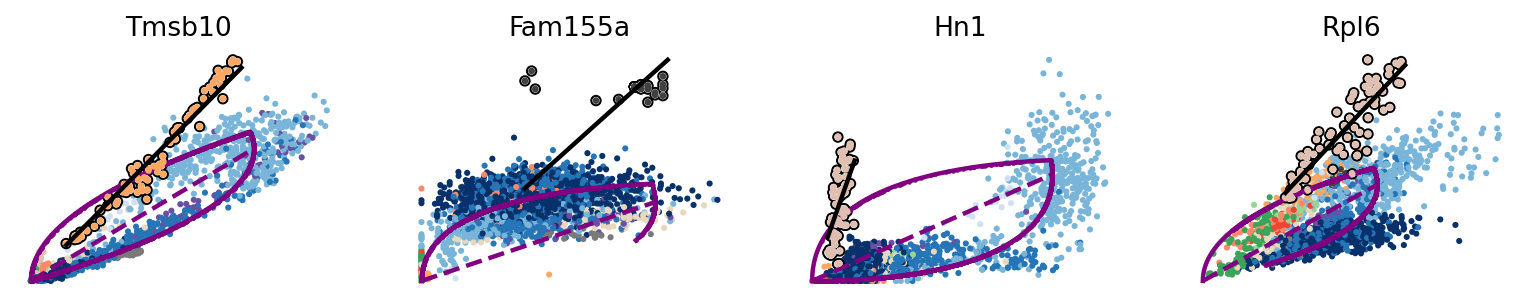

In [10]:
kwargs = dict(linewidth=2, add_linfit=True, frameon=False)
scv.pl.scatter(adata, basis=var_names, add_outline='fit_diff_kinetics', **kwargs)


## ScGeo add-on: geometry-aware *velocity / kinetic* differences between clusters

The original **differential kinetics** section (scVelo) focuses on *gene-level* differences in kinetic parameters across groups.
ScGeo gives a complementary, **geometry-first QC view**:

- Treat the **velocity vectors in embedding space** (e.g. `adata.obsm["velocity_umap"]`) as a field describing *where cells want to move next*.
- Quantify how different two groups' dynamics look **in the same geometry** (UMAP/PCA), using:
  - **Shift** between groups in an embedding (`scgeo.tl.shift`) as a coarse “state displacement” vector.
  - **Velocity–delta alignment** (`scgeo.tl.velocity_delta_alignment`) to ask whether velocities point **along** the group displacement direction.
  - Optional **distribution tests** to compare velocity *magnitudes* (“speed”) or vector distributions.

This is intentionally a **toy demonstration**: we are not claiming true developmental directionality here.
The goal is to show how ScGeo can *audit* kinetic differences in a reproducible, embedding-native way.

### What you should expect (sanity checks)

When you compare two clusters (states):

- If they are **adjacent along a trajectory**, the group-to-group shift should point roughly from the earlier to later state, and velocities in the transition region may align with it.
- If they are **unrelated branches**, shift may be large but velocity–delta alignment can be low/ambiguous.
- If the embedding mixes groups heavily, both shift and alignment may be unstable (this is a feature: it tells you the geometry is not informative for that contrast).

In [11]:
# --- ScGeo: velocity/kinetic difference demo (cluster-vs-cluster) ---
import scgeo as sg

# scVelo usually stores embedding-space velocities under `velocity_<basis>`
# Ensure `velocity_umap` exists (name used by scVelo velocity_embedding when basis="umap")
if "velocity_umap" not in adata.obsm:
    import scvelo as scv
    scv.tl.velocity_embedding(adata, basis="umap")

# Choose two clusters to compare.
# You can set these explicitly after you look at the UMAP.
clusters = adata.obs["clusters"].astype(str)
cluster_counts = clusters.value_counts()
group0, group1 = cluster_counts.index[:2].tolist()   # largest two clusters as a safe default

print("Comparing clusters:", group0, "vs", group1)
print("Counts:", int(cluster_counts[group0]), "vs", int(cluster_counts[group1]))


Comparing clusters: Granule mature vs Granule immature
Counts: 1070 vs 785


In [12]:
adata

AnnData object with n_obs × n_vars = 2930 × 2000
    obs: 'clusters', 'age(days)', 'clusters_enlarged', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'fit_diff_kinetics', 'fit_pval_kinetics'
    uns: 'clusters_colors', 'log1p', 'pca', 'neighbors', 'velocity_params', 'velocity_graph', 'velocity_graph_neg', 'recover_dynamics'
    obsm: 'X_umap', 'X_pca', 'velocity_umap'
    varm: 'PCs', 'loss', 'fit_pvals_kinetics'
    layers: 'ambiguous', 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'variance_velocity', 'fit_t', 'fit_tau', 'fit_tau_'
    obsp: 'distances', 'connectivi

In [13]:

# 1) Coarse state displacement (delta) between the two groups in the embedding.
#    This is not a biological claim; it's a geometric summary of how separated the groups are.
sg.tl.shift(
    adata,
    rep="X_umap",                 # compare the two groups in UMAP geometry
    condition_key="clusters",
    group0=group0,
    group1=group1,
    store_key="scgeo",
)


scgeo uns keys: ['shift', 'align_vectors']
candidate obs keys: ['scgeo_vel_delta_align']


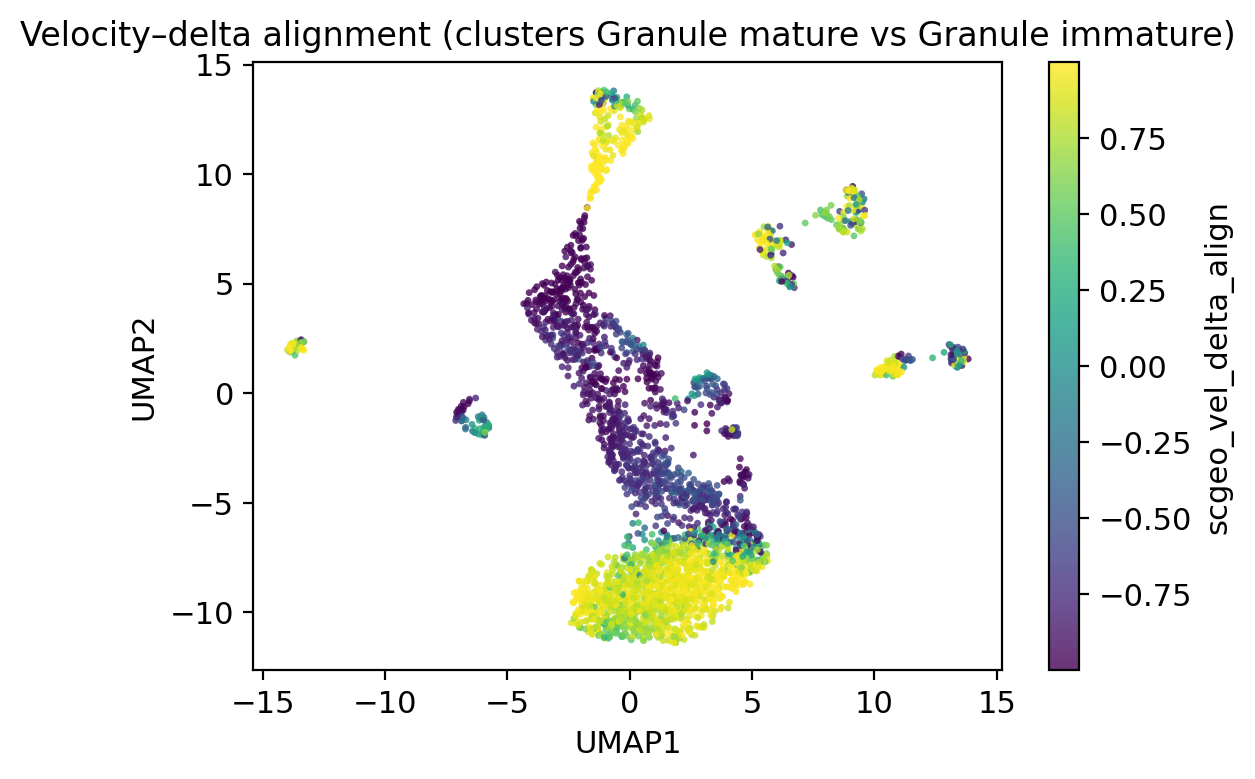

In [15]:

# 2) Velocity–delta alignment: do velocity vectors point along the group displacement direction?
#    This is the ScGeo-style "are dynamics consistent with the geometry of the contrast?" check.
sg.tl.velocity_delta_alignment(
    adata,
    velocity_key="velocity_umap",
    rep_for_shift="X_umap",
    condition_key="clusters",   # <-- key fix (or "clusters_enlarged")
    group0=group0,
    group1=group1,
    store_key="scgeo",
)


# Inspect what keys were written so we can plot without guessing.
print("scgeo uns keys:", list(adata.uns.get("scgeo", {}).keys()))
new_obs_keys = [k for k in adata.obs.columns if k.startswith("vel_") or "align" in k.lower()]
print("candidate obs keys:", new_obs_keys)

# 3) Plot: alignment score on UMAP (we try to auto-detect the created score key).
#    If nothing is detected, check `adata.obs.columns` and plug the key into sg.pl.score_embedding manually.
align_key = None
for k in new_obs_keys:
    if "align" in k.lower():
        align_key = k
        break

if align_key is not None:
    sg.pl.score_embedding(
        adata,
        align_key,
        basis="umap",
        title=f"Velocity–delta alignment (clusters {group0} vs {group1})",
        show=True,
    )
else:
    print("No obvious alignment score key found. Inspect `adata.obs.columns` and plot manually.")

### How to interpret the *velocity–delta alignment* plot

Think of two vectors:

1. **Delta (shift) vector**: the average displacement from group0 → group1 in the embedding.
2. **Velocity vector**: scVelo’s estimated “next-step” direction for each cell in the same embedding.

The alignment score is typically a cosine-like quantity:

- **High (positive)**: velocities point *toward* group1 along the group displacement direction.
- **Near 0**: velocities are orthogonal / ambiguous with respect to the group contrast.
- **Negative**: velocities point *against* the group displacement direction (often indicating branching, poor embedding geometry for that contrast, or that the chosen groups are not ordered along a single transition).

What you want to see depends on your hypothesis:
- For a **putative transition** (early → late), you’d expect higher alignment around the boundary.
- For **two unrelated clusters**, low/patchy alignment is totally reasonable.

If you get an “all-noise” picture:
- Try different `(group0, group1)` that are visually adjacent in UMAP.
- Consider running this in PCA space (`rep="X_pca"`, `velocity_key="velocity_pca"`) for a more linear geometry.

In *Tmsb10*, for instance, Endothelial display a kinetic behaviour (outlined, with the black line fitted through), that cannot be well explained by the overall dynamics (purple curve).

/mnt/d/scgeo/.venv/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/mnt/d/scgeo/.venv/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


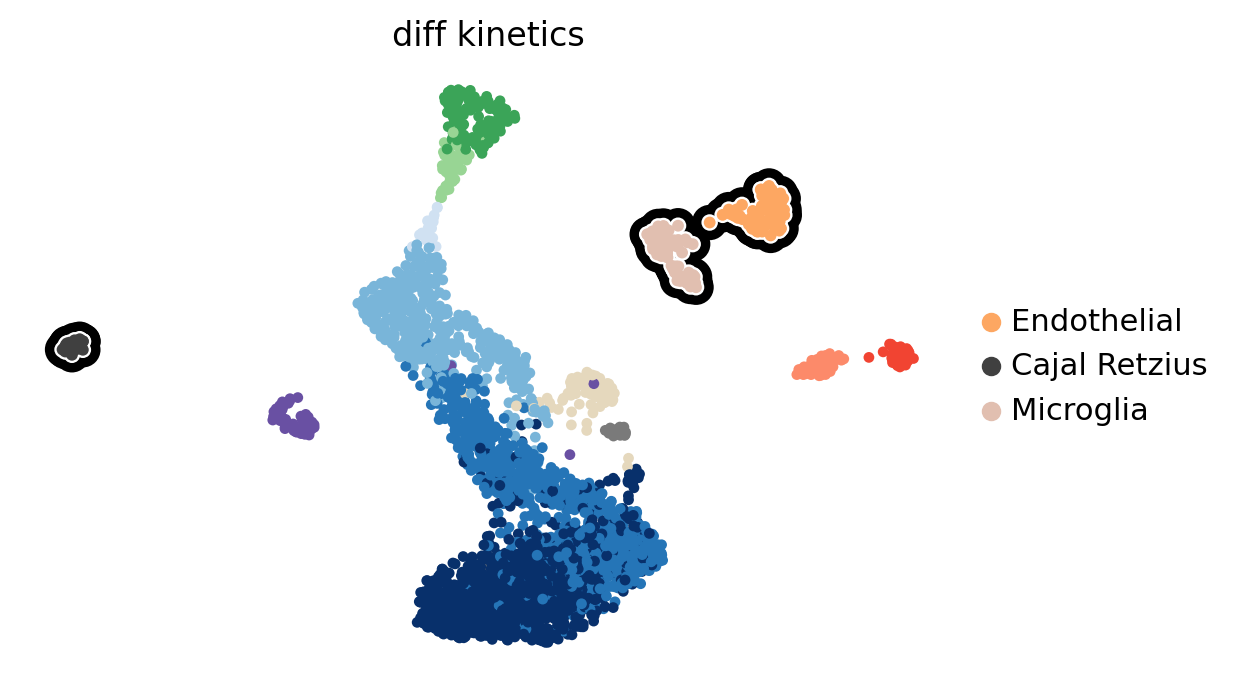

In [16]:
diff_clusters=list(adata[:, var_names].var['fit_diff_kinetics'])
scv.pl.scatter(adata, legend_loc='right', size=60, title='diff kinetics',
               add_outline=diff_clusters, outline_width=(.8, .2))
